https://github.com/gilbutITbook/080324/tree/master  
20장

# 20장 전이 학습을 통해 딥러닝의 성능 극대화하기

## 1. 소규모 데이터셋으로 만드는 강력한 학습 모델

### 실습: 치매 환자의 뇌인지 일반인의 뇌인지 예측하기

## 1. 데이터셋 준비하기
- 폴더 단위로 이미지만 준비하면
- 치매 환자의 뇌인지 일반인의 뇌인지 예측하기
- 폴더에 일반인과 치매 환자의 뇌 사진을 나누어 준비
  - 상황에 따라 train과 test 자료는 프로그램이 알아서 나누기도 함.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # 폴더에서 이미지를 읽고, 이미지 사이즈 통일, 전처리 등 제공
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

# 깃허브에 준비된 데이터를 가져옵니다.
!git clone https://github.com/taehojo/data-ch20.git


Cloning into 'data-ch20'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 265 (delta 0), reused 265 (delta 0), pack-reused 0
Receiving objects: 100% (265/265), 1.86 MiB | 10.71 MiB/s, done.


In [ ]:
# 학습셋의 변형을 설정하는 부분입니다.
# 증강
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )

train_generator = train_datagen.flow_from_directory(
       './data-ch20/train',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       './data-ch20/test',   # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
# x_train 데이터는 총 5개씩 * 32개 = 160개의 데이터셋 (ad=80개, normal=80개)로 구성

print(len(train_generator))  # 배치사이즈 5개씩 묶었을 때 몇개의 묶음이 있는가? 32개 묶음이 있다.
print(len(train_generator[0]))  # 그 중 첫번째 묶음은 몇개로 구성되어 있는가? (이미지 로더기는 똑같음. x와 y로)
print(len(train_generator[0][0]))  # 첫 번째 묶음의 첫 자료(즉, x자료의 개수, 즉 배치개수확인)
train_generator[0][1], len(train_generator[0][1])  # 첫번째 데이터의 5개의 레이블값

32
2
5


(array([1., 1., 1., 1., 0.], dtype=float32), 5)

In [ ]:
# 앞서 배운 CNN 모델을 만들어 적용해 보겠습니다.
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [ ]:
# 모델 실행의 옵션을 설정합니다.
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다
history = model.fit(
       train_generator,
       epochs=10,
       validation_data=test_generator,
       validation_steps=10,
       callbacks=[early_stopping_callback])

Epoch 1/10
32/32 [==============================] - 10s 265ms/step - loss: 0.7012 - accuracy: 0.4625 - val_loss: 0.6877 - val_accuracy: 0.6600
Epoch 2/10
32/32 [==============================] - 8s 255ms/step - loss: 0.6930 - accuracy: 0.4875 - val_loss: 0.6878 - val_accuracy: 0.5800
Epoch 3/10
32/32 [==============================] - 7s 211ms/step - loss: 0.6883 - accuracy: 0.5375 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 8s 250ms/step - loss: 0.6822 - accuracy: 0.5562 - val_loss: 0.6711 - val_accuracy: 0.7200
Epoch 5/10
32/32 [==============================] - 6s 199ms/step - loss: 0.6808 - accuracy: 0.5688 - val_loss: 0.6652 - val_accuracy: 0.8000
Epoch 6/10
32/32 [==============================] - 7s 225ms/step - loss: 0.6876 - accuracy: 0.5500 - val_loss: 0.6573 - val_accuracy: 0.6000
Epoch 7/10
32/32 [==============================] - 8s 238ms/step - loss: 0.6556 - accuracy: 0.6750 - val_loss: 0.6268 - val_accuracy: 0.5600
Epoch

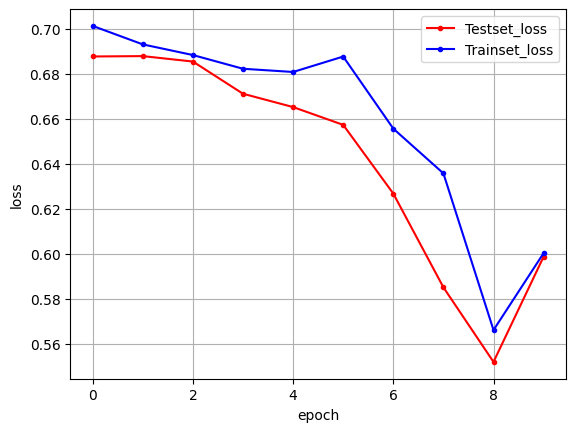

In [ ]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
test = test_generator[0][0]  # 5개 세트 이미지
yhat = model.predict(test)
print(yhat)  # sigmoid 함수는 0~1값 사이로만 출력하게 되어 있고, 보통 0.5 기준(임계값)해서 0.1값 정함.

# 임계구역은 사용자가 조정해도 됨. (정밀도, 재현율, F1 스코어의 분류평가지표, ROC 차트도 확인해서 임계값 찾아야함.)
result = []

for x in yhat[:, 0]:
  if x > 0.5:
    result.append(1)
  else:
    result.append(0)

result

1/1 [==============================] - 0s 63ms/step
[[0.7166758 ]
 [0.7910052 ]
 [0.5297593 ]
 [0.5861129 ]
 [0.39745137]]


[1, 1, 1, 1, 0]

In [ ]:
test_label = test_generator[0][1]  # 5개 세트 레이블
test_label

array([1., 1., 0., 0., 0.], dtype=float32)

## 2. 전이 학습으로 모델 성능 극대화하기

### 실습: 전이 학습 실습하기

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# 학습셋의 변형을 설정하는 부분입니다.
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )


train_generator = train_datagen.flow_from_directory(
       './data-ch20/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋의 정규화를 설정합니다.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       './data-ch20/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 전이학습을 사용하게 되면, 개, 고양이 이미지도 구별한 특징값을 미세하게 구별하는 파라미터 값을 사용할 수 있음.
# 단 깊은 레이어층 (예를 들어 16개의 레이어층이면 약 10번째 층, 즉 하단층 부터는 내 자료랑 안맞을 확률이 있어서)
# 전이학습 모델에서도 일정한 레이어를 사용하지 않아야함. (단 레이어 반응 다 확인해야함.)

##################################################################
# VGG16 모델을 불러옵니다.
# 기존의 vgg 모델의 224, 224가 아닌 내 사이즈 150, 150으로 하려면 가장 상단을 사용하지 않겠다.
# 이러면 flatten 레이어부터 사용하지 않게끔
# 즉 내가 추가해야 함.

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False  # 기존모델의 conv2D의 param에 전송되는 특정 맵값은 훈련하지 않겠다. 기존거 사용.
transfer_model.summary()

# 우리의 모델을 설정합니다.
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
58900480/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 12

In [ ]:
# 모델의 실행 옵션을 설정합니다.
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       validation_steps=10,
       callbacks=[early_stopping_callback])

Epoch 1/20
32/32 [==============================] - 7s 217ms/step - loss: 0.7590 - accuracy: 0.5688 - val_loss: 0.5409 - val_accuracy: 0.7800
Epoch 2/20
32/32 [==============================] - 7s 224ms/step - loss: 0.5509 - accuracy: 0.7125 - val_loss: 0.5420 - val_accuracy: 0.7600
Epoch 3/20
32/32 [==============================] - 7s 208ms/step - loss: 0.4324 - accuracy: 0.8188 - val_loss: 0.4058 - val_accuracy: 0.8200
Epoch 4/20
32/32 [==============================] - 7s 217ms/step - loss: 0.4192 - accuracy: 0.8313 - val_loss: 0.3407 - val_accuracy: 0.9200
Epoch 5/20
32/32 [==============================] - 7s 208ms/step - loss: 0.3139 - accuracy: 0.8813 - val_loss: 0.2570 - val_accuracy: 0.9600
Epoch 6/20
32/32 [==============================] - 7s 220ms/step - loss: 0.2795 - accuracy: 0.9125 - val_loss: 0.2508 - val_accuracy: 0.9200
Epoch 7/20
32/32 [==============================] - 7s 228ms/step - loss: 0.2519 - accuracy: 0.9125 - val_loss: 0.3089 - val_accuracy: 0.8600
Epoch 

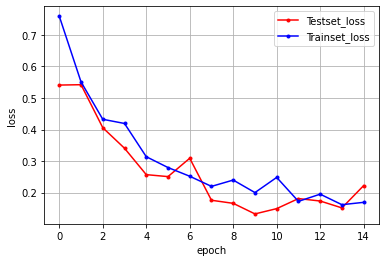

In [ ]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()